In [ ]:
!pip list | grep torch
!pip list | grep transformers

torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchsummary                       1.5.1
torchvision                        0.20.1+cu121
sentence-transformers              3.2.1
transformers                       4.46.2


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers --upgrade

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers --upgrade

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.3/838.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the dataset
base_dir = "/content/drive/MyDrive/datasetsampah"

In [ ]:
# Define class names and their descriptions
class_descriptions = {
    "compost": "an image of compostable waste, such as food scraps, leaves, or biodegradable materials",
    "recyclable": "an image of recyclable waste, such as plastic, metal, or paper materials"
}



model_name = "openai/clip-vit-base-patch16"  # Change as needed

In [ ]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, processor):
        self.root_dir = root_dir
        self.processor = processor
        self.images = []
        self.labels = []

        # Verify the root directory exists
        if not os.path.exists(root_dir):
            raise ValueError(f"Directory not found: {root_dir}")

        print(f"Examining directory: {root_dir}")
        print(f"Contents of root directory: {os.listdir(root_dir)}")

        # Load all images and labels
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue

            print(f"\nProcessing class: {class_name}")
            print(f"Class path: {class_path}")

            def is_image_file(filename):
                return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))

            def find_images_recursive(directory):
                found_images = []
                try:
                    for item in os.listdir(directory):
                        item_path = os.path.join(directory, item)
                        if os.path.isfile(item_path) and is_image_file(item):
                            found_images.append(item_path)
                        elif os.path.isdir(item_path):
                            found_images.extend(find_images_recursive(item_path))
                except Exception as e:
                    print(f"Error accessing {directory}: {str(e)}")
                return found_images

            class_images = find_images_recursive(class_path)
            print(f"Found {len(class_images)} images in class {class_name}")

            if class_images:
                self.images.extend(class_images)
                self.labels.extend([class_name] * len(class_images))

        if not self.images:
            raise ValueError("No valid images found in the dataset")

        print(f"\nTotal images loaded: {len(self.images)}")
        print(f"Sample image paths:")
        for i in range(min(5, len(self.images))):
            print(f"  {self.images[i]}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image_path = self.images[idx]
            if not os.path.exists(image_path):
                print(f"File does not exist: {image_path}")
                raise FileNotFoundError(f"File not found: {image_path}")

            image = Image.open(image_path).convert('RGB')
            label = self.labels[idx]

            inputs = self.processor(images=image, return_tensors="pt", padding=True)
            return inputs['pixel_values'][0], label

        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))


In [ ]:
def evaluate_zero_shot_performance(model, dataloader, text_inputs, class_descriptions):
    model.eval()
    all_predictions = []
    all_true_labels = []
    confidence_scores = []

    print("\nEvaluating Zero-Shot Learning Performance...")

    # Map class labels to indices
    label_to_index = {label: idx for idx, label in enumerate(class_descriptions.keys())}

    with torch.no_grad():
        for batch_images, batch_labels in tqdm(dataloader):
            # Get image features
            image_features = model.get_image_features(pixel_values=batch_images)

            # Get text features
            text_features = model.get_text_features(**text_inputs)

            # Calculate similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            # Get predictions
            predicted_labels = similarity.argmax(dim=-1)
            confidence, _ = similarity.max(dim=-1)

            all_predictions.extend(predicted_labels.cpu().numpy())

            # Map batch labels to indices
            for label in batch_labels:
                if label in label_to_index:
                    all_true_labels.append(label_to_index[label])
                else:
                    print(f"Skipping unknown label: {label}")

            # Save confidence scores
            confidence_scores.extend(confidence.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    class_names = list(class_descriptions.keys())

    # Generate classification report
    report = classification_report(
        [class_names[i] for i in all_true_labels],
        [class_names[i] for i in all_predictions],
        target_names=class_names
    )

    # Create confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate average confidence per class
    class_confidences = {}
    for true_label, pred_label, conf in zip(all_true_labels, all_predictions, confidence_scores):
        class_name = class_names[true_label]
        if class_name not in class_confidences:
            class_confidences[class_name] = []
        if true_label == pred_label:  # Only consider correct predictions
            class_confidences[class_name].append(conf)

    avg_confidences = {cls: np.mean(confs) if confs else 0
                      for cls, confs in class_confidences.items()}

    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'avg_confidences': avg_confidences,
        'confidence_scores': confidence_scores
    }


In [ ]:
# Load model and processor
print("Loading CLIP model and processor...")
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Prepare text inputs
text_descriptions = list(class_descriptions.values())
text_inputs = processor(text=text_descriptions, return_tensors="pt", padding=True)

# Create dataset and dataloader
print("\nCreating dataset...")
dataset = WasteDataset(base_dir, processor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Loading CLIP model and processor...

Creating dataset...
Examining directory: /content/drive/MyDrive/datasetsampah
Contents of root directory: ['compost', 'recyclable', 'Klasifikasi data sampah dengan CNN.docx', 'CNN.ipynb', 'cnn_efficientnetb3.h5', 'model_training_sampah.h5']

Processing class: compost
Class path: /content/drive/MyDrive/datasetsampah/compost
Found 1759 images in class compost

Processing class: recyclable
Class path: /content/drive/MyDrive/datasetsampah/recyclable
Found 14221 images in class recyclable

Total images loaded: 15980
Sample image paths:
  /content/drive/MyDrive/datasetsampah/compost/eggshells/egg (375).png
  /content/drive/MyDrive/datasetsampah/compost/eggshells/egg (486).png
  /content/drive/MyDrive/datasetsampah/compost/eggshells/egg (337).png
  /content/drive/MyDrive/datasetsampah/compost/eggshells/egg (445).png
  /content/drive/MyDrive/datasetsampah/compost/eggshells/egg (442).png



Evaluating Zero-Shot Learning Performance...


100%|██████████| 500/500 [6:11:37<00:00, 44.59s/it]


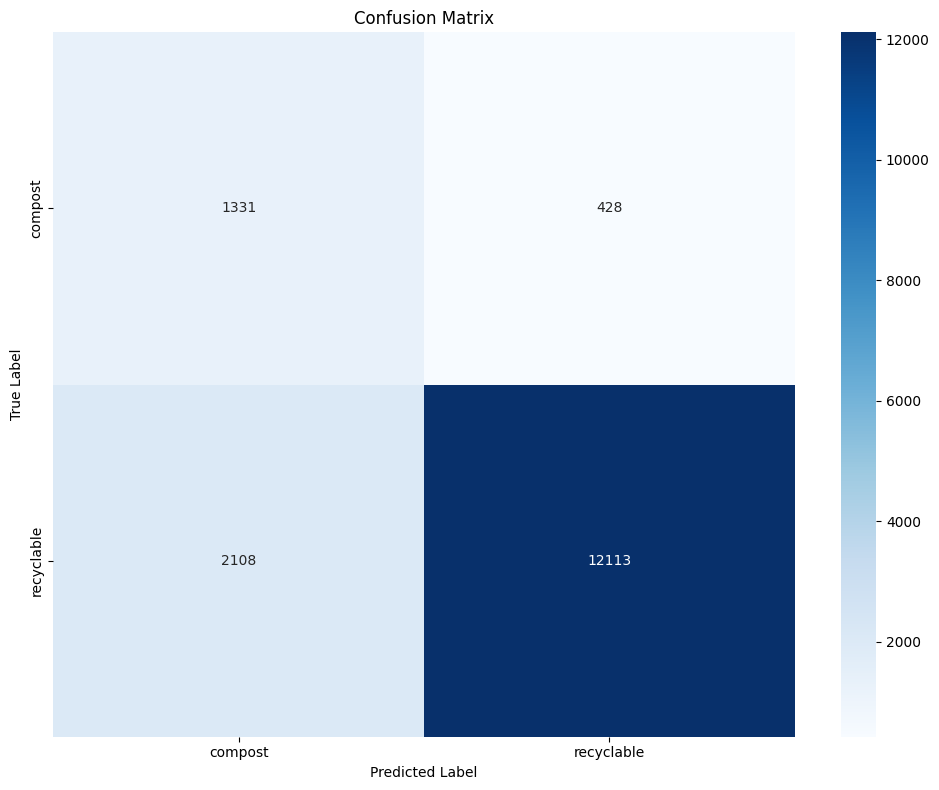


=== Zero-Shot Learning Performance ===

Overall Accuracy: 0.8413

Classification Report:
              precision    recall  f1-score   support

     compost       0.39      0.76      0.51      1759
  recyclable       0.97      0.85      0.91     14221

    accuracy                           0.84     15980
   macro avg       0.68      0.80      0.71     15980
weighted avg       0.90      0.84      0.86     15980


Average Confidence Scores per Class:
compost: 0.9984
recyclable: 0.9988


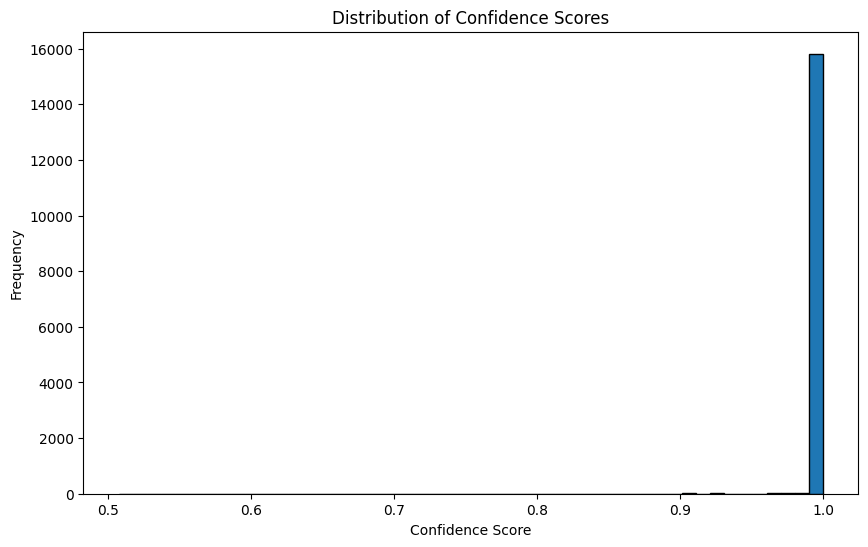

In [ ]:
# Evaluate the model
try:
    results = evaluate_zero_shot_performance(model, dataloader, text_inputs, class_descriptions)

    # Print results
    print("\n=== Zero-Shot Learning Performance ===")
    print(f"\nOverall Accuracy: {results['accuracy']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])
    print("\nAverage Confidence Scores per Class:")
    for class_name, conf in results['avg_confidences'].items():
        print(f"{class_name}: {conf:.4f}")

    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(results['confidence_scores'], bins=50, edgecolor='black')
    plt.title('Distribution of Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.show()

except Exception as e:
    print(f"\nError during evaluation: {str(e)}")
    raise
